# Customers Dataset


### 0. Imports

In [2]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn

#Patterns Mining
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")
import utils

##### Loading the CSV dataset

In [30]:
dataset_path = "../datasets/Costumers.csv"
dtf = pd.read_csv(dataset_path)

In [31]:
dtf.head(10)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
5,100000006,0,0,35,1,144848,0,0
6,100000007,0,0,53,1,156495,1,1
7,100000008,0,0,35,1,193621,2,1
8,100000009,0,1,61,2,151591,0,0
9,100000010,0,1,28,1,174646,2,0


In [32]:
#check if any column is null
dtf.isnull().any()

ID                 False
Sex                False
Marital status     False
Age                False
Education          False
Income             False
Occupation         False
Settlement size    False
dtype: bool

##### Defining numeric and categorical columns

In [34]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]
ordinals = list(set(numeric_columns) - set(very_numerical))

##### Filling Null Values with the column's mean

In [35]:
na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

##### Dropping and filling NA values for categorical columns:

1. drop if at least 70% are NA:

In [36]:
nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]

In [37]:
dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

2. Fill with a new 'na' category:

In [38]:
dtf[categorical_columns]= dtf[categorical_columns].fillna('na')

##### one hot encoding/lable encoding Categorical data for clustreing

In [39]:
dtf_encoded = utils.label_encoding(dtf.copy(), categorical_columns)
dtf_encoded.dtypes

ID                 int64
Sex                int64
Marital status     int64
Age                int64
Education          int64
Income             int64
Occupation         int64
Settlement size    int64
dtype: object

#### Find best k

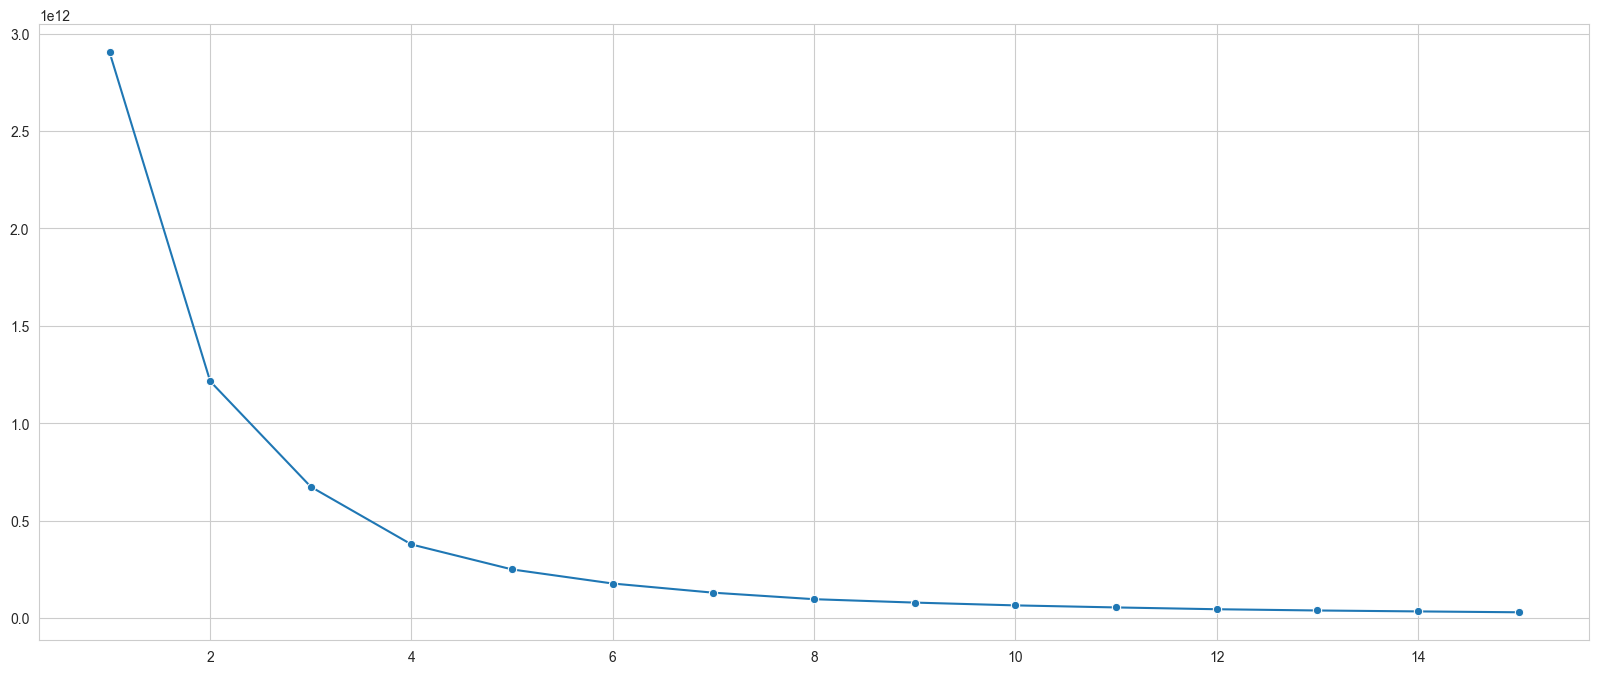

In [40]:
utils.opt_kmeans(dtf_encoded,15)

In [41]:
clusters = utils.run_k_means(6,dtf_encoded,dtf)
lens = [len(a) for a in clusters.values()]
lens

[658, 93, 322, 324, 576, 27]

##### removing small clusters

In [42]:
labels2remove = []
for label,cdf in clusters.items():    #removing clusters under 1% in size. this is just so we dont get things with very high relative support
    if len(cdf) < len(dtf)/100:
        labels2remove.append(label)
for label in labels2remove:
    del clusters[label]
len(clusters)


6

### 2. Using Apriori on a each cluster:

### Preprocessing clusters for apriori

In [43]:
clusters[list(clusters.keys())[0]][:1]

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
2,100000003,0,0,49,1,89210,0,0


In [44]:
for label,cdf in clusters.items():
    clusters[label] = utils.preprocess_4_apriori(cdf,very_numerical)
clusters[list(clusters.keys())[0]]

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
2,very low,0,0,very high,1,very low,0,0
10,very low,1,1,very low,1,high,1,0
12,very low,1,1,very low,1,high,1,2
13,very low,0,0,very high,2,very low,0,0
14,very low,1,1,medium,1,medium,1,1
...,...,...,...,...,...,...,...,...
1989,very high,1,1,very low,1,medium,0,0
1992,very high,1,0,very high,1,low,0,0
1993,very high,1,0,high,1,very low,0,0
1994,very high,0,0,very high,1,very high,1,0


In [45]:
clusters[list(clusters.keys())[0]][:1]

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
2,very low,0,0,very high,1,very low,0,0


In [46]:
patitioned_total_rules = set()

for label,cdf in clusters.items():
    transactions = utils.convert_ds_to_transactions(cdf)
    itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)
    patitioned_total_rules.update(rules)

patitioned_total_rules=list(patitioned_total_rules)
len(patitioned_total_rules)

30

### do apriori on the initial dataset for comparison

In [56]:
transactions = utils.convert_ds_to_transactions(dtf)
unpatitioned_total_itemsets, unpatitioned_total_rules = apriori(transactions, min_support=0.3, min_confidence=0.6,output_transaction_ids=False)

In [57]:
len(unpatitioned_total_rules)

10

## 2. Analyzing the rules:
We need a measures of interestingness to evaluate our results.

We first use the Lift measurement taught in class.
on top of that we use the Conviction and Leverage measurements.
formulas and meaning of those can be seen in the report file.

### Lift comparison

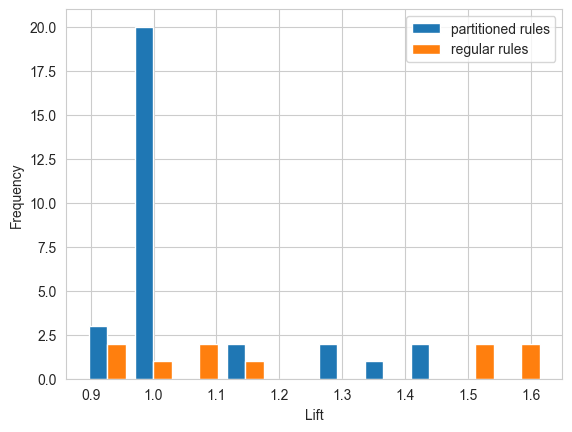

In [58]:
partitioned_lift_arr = [rule.lift for rule in patitioned_total_rules]
unpartitioned_lift_arr = [rule.lift for rule in unpatitioned_total_rules]
plt.hist([partitioned_lift_arr,unpartitioned_lift_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Lift')
plt.ylabel('Frequency')

plt.show()

### Conviction comparison

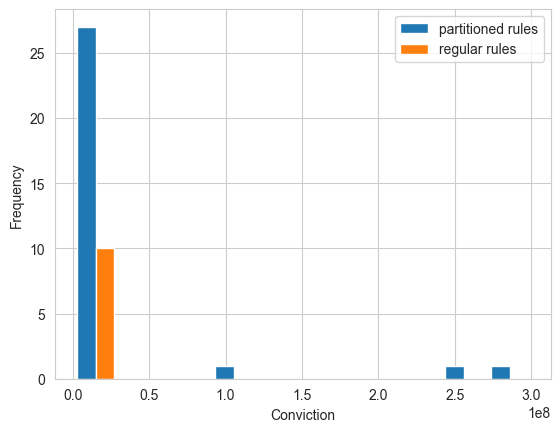

In [59]:
#creating conviction graph for both the partitioned rules and the unpartitioned rules
partitioned_conviction_arr = [rule.conviction for rule in patitioned_total_rules]
unpartitioned_conviction_arr = [rule.conviction for rule in unpatitioned_total_rules]
plt.hist([partitioned_conviction_arr,unpartitioned_conviction_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Conviction')
plt.ylabel('Frequency')

plt.show()

### Confidence comparison


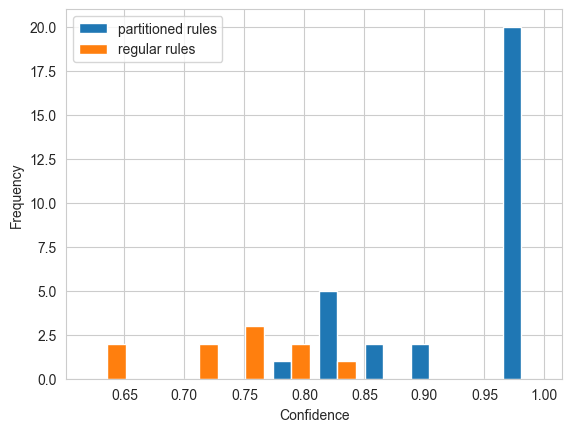

In [60]:
partitioned_conf_arr = [rule.confidence for rule in patitioned_total_rules]
unpartitioned_conf_arr = [rule.confidence for rule in unpatitioned_total_rules]
plt.hist([partitioned_conf_arr,unpartitioned_conf_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.show()